In [1]:
# Import necessary libraries and load the adult income dataset
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from fairlearn.preprocessing import CorrelationRemover
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, selection_rate

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from plotting import plot_correlation_heatmap, plot_dendrogram, highlight_min_max

Fetch Adult Income UCI dataset

In [3]:
data = fetch_openml(name='adult', version=2)

X = pd.DataFrame(data.data, columns=data.feature_names)
y = (data.target == '>50K') * 1
X.sample(3)

c:\Users\shkco\code\tds\tds_venv\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
40511,51.0,Local-gov,133336.0,Masters,14.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024.0,0.0,40.0,United-States
13430,62.0,Private,193881.0,Masters,14.0,Widowed,Exec-managerial,Not-in-family,White,Female,0.0,0.0,35.0,United-States
14830,49.0,Self-emp-not-inc,340755.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States


Basic EDA for performed for the need of this demo

In [4]:
# nominal
X['workclass'].unique()

['Private', 'Local-gov', NaN, 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']
Categories (8, object): ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

In [5]:
# ordinal
X['education'].unique()

['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool']
Length: 16
Categories (16, object): ['10th', '11th', '12th', '1st-4th', ..., 'Masters', 'Preschool', 'Prof-school', 'Some-college']

In [6]:
y.sample(3)

20932    0
35872    0
37874    0
Name: class, dtype: int32

In [7]:
# correct dtypes in terms of categorical/numerical
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  float64 
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  float64 
 3   education       48842 non-null  category
 4   education-num   48842 non-null  float64 
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  float64 
 11  capital-loss    48842 non-null  float64 
 12  hours-per-week  48842 non-null  float64 
 13  native-country  47985 non-null  category
dtypes: category(8), float64(6)
memory usage: 2.6 MB


In [8]:
# Identify the categorical and numerical columns
cat_cols = [X.columns[i] for i, dtype in enumerate(X.dtypes) if dtype == "category"]
num_cols = [X.columns[i] for i, dtype in enumerate(X.dtypes) if dtype != "category"]

# Identify the ordinal columns
ordinal_cols = ['education']

# Identify the nominal columns
nominal_cols = list(set(cat_cols) - set(ordinal_cols))
nominal_cols.remove('race')
nominal_cols

['marital-status',
 'native-country',
 'sex',
 'workclass',
 'occupation',
 'relationship']

Perform necessary preprocessing in order to run a logsitic regression

In [9]:
# Define the categories for the ordinal features
education_categories = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', 
    '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc',
    'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate'
]

# Define the transformers for the categorical and numerical columns
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[education_categories]))
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


def race_to_binary(X):
    X['white'] = X['race'].replace({'White': 1, 'Black': 0, 'Asian-Pac-Islander': 0, 'Amer-Indian-Eskimo': 0, 'Other': 0})
    X = X.drop('race', axis=1)
    return X

def race_to_binary_feature_names(fn_transformer, input_features):
  return [feat if feat != 'race' else 'white' for feat in input_features]

race_transformer = Pipeline(steps=[
    ('race_binaizer', FunctionTransformer(race_to_binary, feature_names_out=race_to_binary_feature_names))
])


In [10]:
nominal_cols

['marital-status',
 'native-country',
 'sex',
 'workclass',
 'occupation',
 'relationship']

In [11]:
# Apply the transformers to the ordinal, nominal, race and numerical columns respectively
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('race', race_transformer, ['race']),
        ('num', num_transformer, num_cols)
    ],
    verbose_feature_names_out=False
    )

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

In [12]:
feature_names = preprocessor.get_feature_names_out()

# Convert the preprocessed data to a dense matrix
X_preprocessed_dense = X_preprocessed.toarray()

# Convert the dense matrix to a Pandas DataFrame with updated column names
X_preprocessed_df = pd.DataFrame(X_preprocessed_dense, columns=feature_names)

X_preprocessed_df

,education,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,native-country_Canada,native-country_China,native-country_Columbia,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,white,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.995129,0.351675,-1.197259,-0.144804,-0.217127,-0.034087
1,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.046942,-0.945524,-0.419335,-0.144804,-0.217127,0.772930
2,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.776316,1.394723,0.747550,-0.144804,-0.217127,-0.034087
3,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.390683,-0.277844,-0.030373,0.886874,-0.217127,-0.034087
4,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-1.505691,-0.815954,-0.030373,-0.144804,-0.217127,-0.841104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,-0.849254,0.640492,0.747550,-0.144804,-0.217127,-0.195490
48838,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.098933,-0.334178,-0.419335,-0.144804,-0.217127,-0.034087
48839,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.411808,-0.357510,-0.419335,-0.144804,-0.217127,-0.034087
48840,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-1.213941,0.111984,-0.419335,-0.144804,-0.217127,-1.648120


In [13]:
feature_names

array(['education', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'marital-status_Widowed', 'native-country_Canada',
       'native-country_China', 'native-country_Columbia',
       'native-country_Cuba', 'native-country_Dominican-Republic',
       'native-country_Ecuador', 'native-country_El-Salvador',
       'native-country_England', 'native-country_France',
       'native-country_Germany', 'native-country_Greece',
       'native-country_Guatemala', 'native-country_Haiti',
       'native-country_Holand-Netherlands', 'native-country_Honduras',
       'native-country_Hong', 'native-country_Hungary',
       'native-country_India', 'native-country_Iran',
       'native-country_Ireland', 'native-country_Italy',
       'native-country_Jamaica', 'native-country_Japan',
       'native-country_Laos', 'native-country_Mexico',
       'native-

In [14]:
X_preprocessed_df.columns

Index(['education', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'native-country_Canada', 'native-country_China',
       'native-country_Columbia', 'native-country_Cuba',
       'native-country_Dominican-Republic', 'native-country_Ecuador',
       'native-country_El-Salvador', 'native-country_England',
       'native-country_France', 'native-country_Germany',
       'native-country_Greece', 'native-country_Guatemala',
       'native-country_Haiti', 'native-country_Holand-Netherlands',
       'native-country_Honduras', 'native-country_Hong',
       'native-country_Hungary', 'native-country_India', 'native-country_Iran',
       'native-country_Ireland', 'native-country_Italy',
       'native-country_Jamaica', 'native-country_Japan', 'native-country_Laos',
       'native-country_Mexico', 'native-country_Nicara

In [15]:
X.sample(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
9187,29.0,Private,163708.0,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,Asian-Pac-Islander,Female,0.0,0.0,45.0,United-States
42303,44.0,Private,113324.0,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
39143,37.0,Self-emp-not-inc,205359.0,Some-college,10.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,15.0,United-States


Protected atrributes

In [16]:
X['race'].unique()

['Black', 'White', 'Asian-Pac-Islander', 'Other', 'Amer-Indian-Eskimo']
Categories (5, object): ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']

In [17]:
X['sex'].unique()

['Male', 'Female']
Categories (2, object): ['Female', 'Male']

Protected attributs after preprocessing

In [18]:
X_preprocessed_df['white'].unique()

array([0., 1.])

In [19]:
X_preprocessed_df['sex_Male'].unique()

array([1., 0.])

Use correlation remover transformer (implemented in fairlearn) that uses linear regression - further explaination is in the PDF

In [20]:
sensitive_attrs = ["white", 'sex_Male']
cr = CorrelationRemover(sensitive_feature_ids=sensitive_attrs)
X_cr = cr.fit_transform(X_preprocessed_df)

feature_names_after_cr = [i for i in X_preprocessed_df.columns if i not in sensitive_attrs] 
X_cr = pd.DataFrame(X_cr, columns=feature_names_after_cr)
X_cr[sensitive_attrs] = X_preprocessed_df[sensitive_attrs]
X_cr.sample(3)

,education,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,native-country_Canada,native-country_China,native-country_Columbia,...,relationship_Unmarried,relationship_Wife,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,white,sex_Male
9888,2.265184,0.000151,0.836228,0.004230,0.033898,0.014690,0.013792,-0.001044,0.003277,-0.000130,...,0.061189,0.029105,3.029394,0.056048,-2.398560,-0.175442,-0.250555,-1.377883,1.0,1.0
22992,7.265184,0.000151,-0.163772,0.004230,1.033898,0.014690,0.013792,-0.001044,0.003277,-0.000130,...,0.061189,0.029105,-1.273918,1.649990,-0.453751,-0.175442,-0.250555,0.639658,1.0,1.0
31841,14.220184,0.000984,1.285872,0.000054,0.197652,0.002979,0.034067,0.005305,-0.010613,0.001519,...,0.044408,0.065802,1.061373,0.600353,-0.323819,-0.141926,-0.201488,-0.071786,0.0,1.0


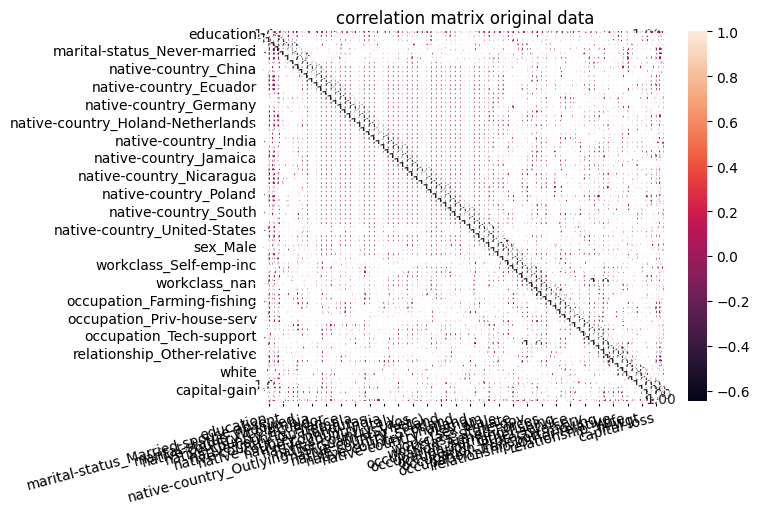

In [21]:
plot_correlation_heatmap(X_preprocessed_df, f'correlation matrix original data')

Unfortunately, since there are many binary features correlation matrix heatmap isn't ideal. Therefore, use dendogram as an alternative

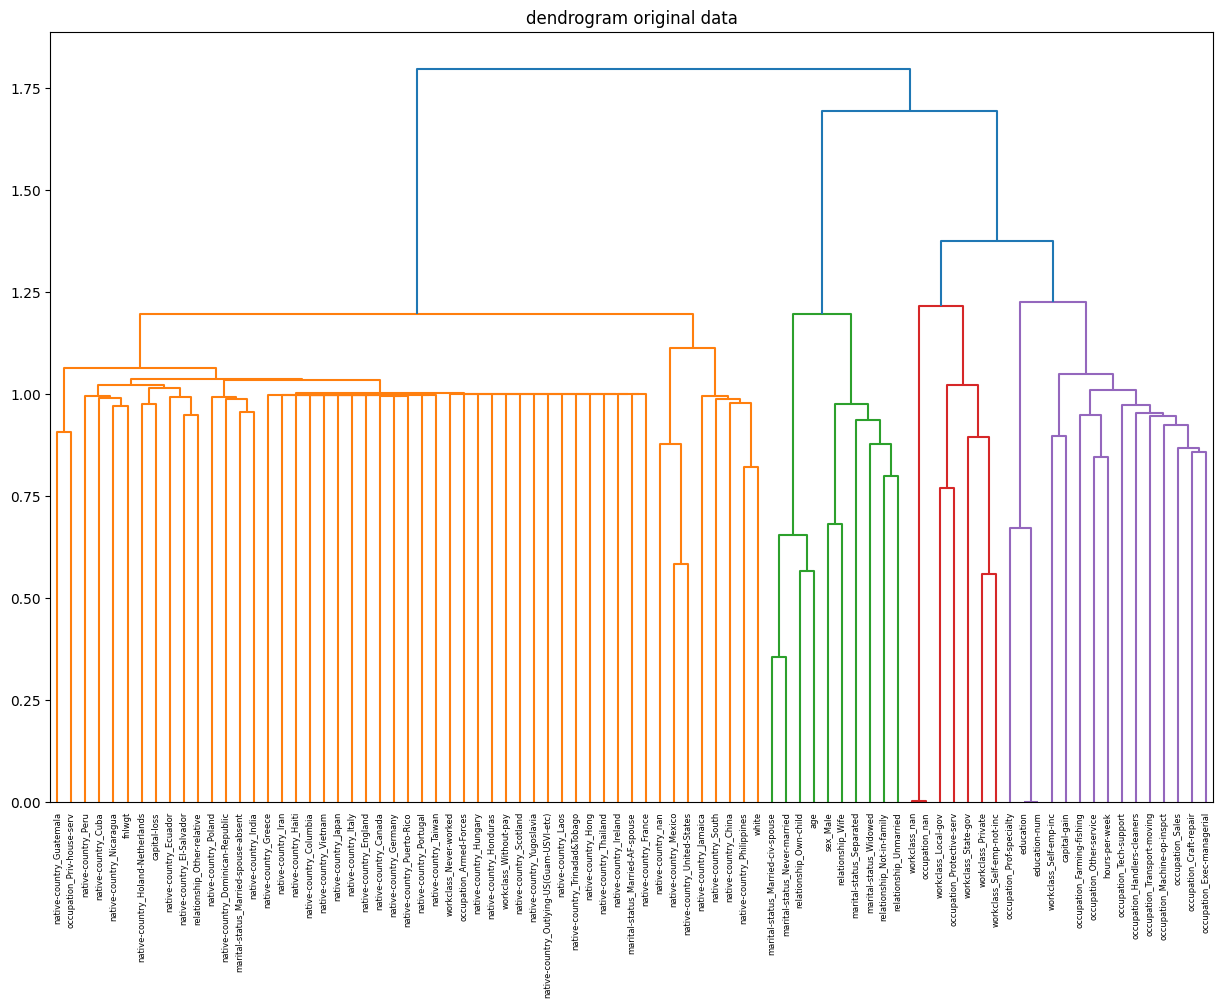

In [22]:
plot_dendrogram(X_preprocessed_df, f'dendrogram original data')

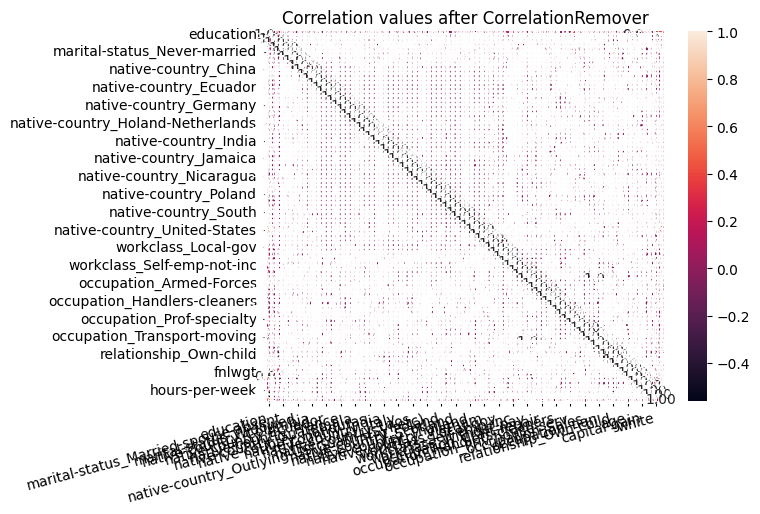

In [23]:
plot_correlation_heatmap(X_cr, f'Correlation values after CorrelationRemover')

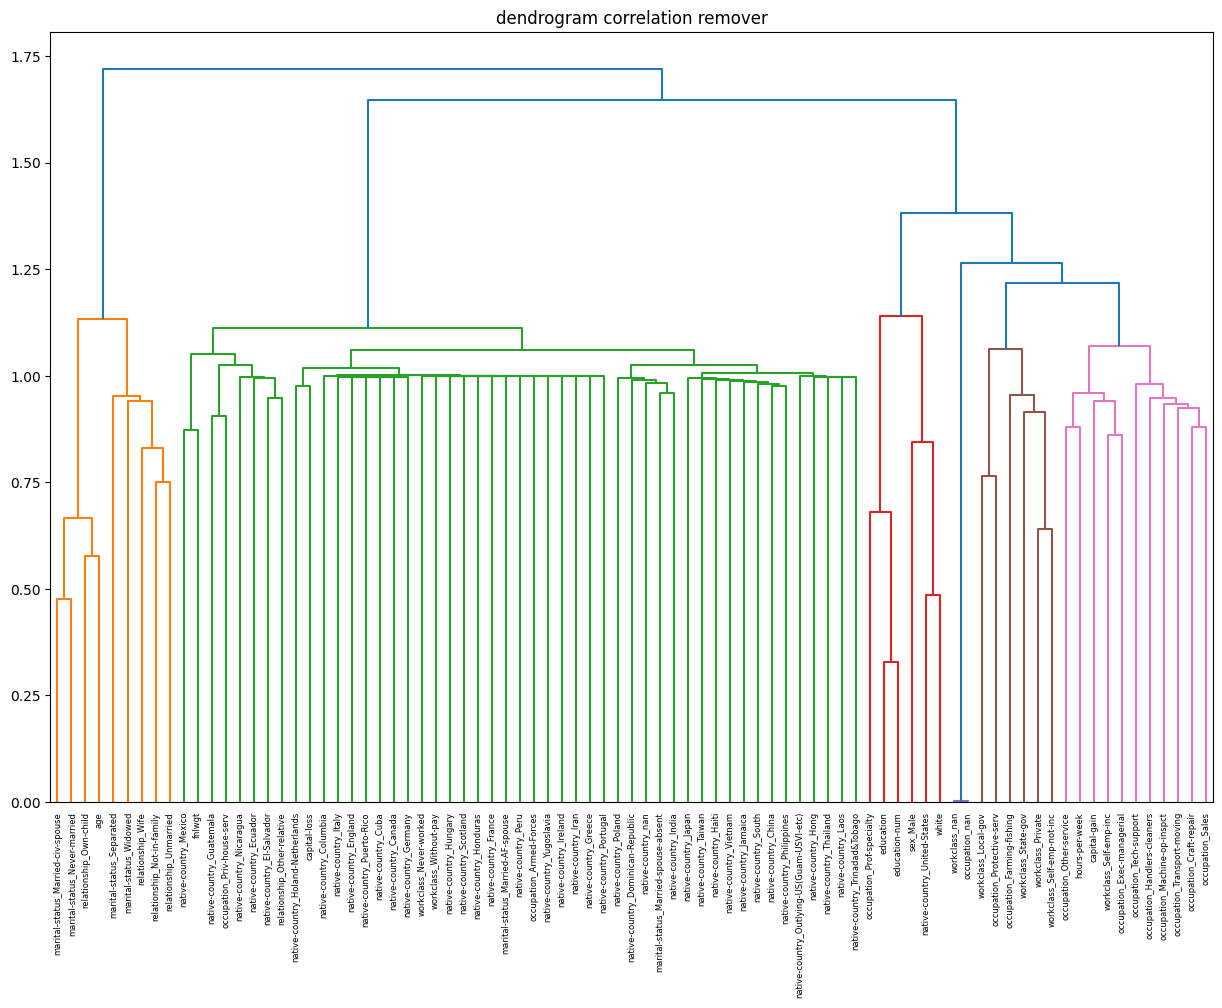

In [24]:
plot_dendrogram(X_cr, f'dendrogram correlation remover')

Baseline - logistic regression without correlation removal

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, shuffle=True, random_state=0, stratify=y)

# save sensetive examples binary vector

# sex
sensitive_attr = 'sex_Male'
X_train_sensitive_sex = X_train[sensitive_attr]
X_test_sensitive_sex =  X_test[sensitive_attr]

# race
sensitive_attr = 'white'
X_train_sensitive_race = X_train[sensitive_attr]
X_test_sensitive_race =  X_test[sensitive_attr]

# Remove the sensitive features from the training data
X_train = X_train.drop(columns=['sex_Male', 'white'])
X_test = X_test.drop(columns=['sex_Male', 'white'])

X_train.sample(3)

,education,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,native-country_Canada,native-country_China,native-country_Columbia,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
27467,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.755371,0.724278,-0.419335,-0.144804,-0.217127,-0.034087
17926,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.359996,-0.528803,-0.419335,-0.144804,-0.217127,-1.648120
36539,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.755371,1.014980,-0.030373,-0.144804,-0.217127,-0.034087


In [26]:
# Train a binary classification model (Logistic Regression)
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred_orig = model.predict(X_test)

Measure performance

In [27]:
performance_table = {}

In [28]:
# Print performance metrics

accuracy = model.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_pred_orig)

performance_table['baseline_#1_logreg'] = {'accuracy': accuracy, 'roc_auc': roc_auc}

print("logreg accuracy:", accuracy)
print("logreg roc_auc:", roc_auc)
print(classification_report(y_test, y_pred_orig))

logreg accuracy: 0.8540280479066434
logreg roc_auc: 0.7689109352665567
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7431
           1       0.74      0.61      0.67      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769



Baseline #2 - Logistic Regression with Linear Transformer Correlation Remover

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_cr, y, test_size=0.2, shuffle=True, random_state=0, stratify=y)

# save sensetive examples binary vector

# sex
sensitive_attr = 'sex_Male'
X_train_sensitive_sex = X_train[sensitive_attr]
X_test_sensitive_sex =  X_test[sensitive_attr]

# race
sensitive_attr = 'white'
X_train_sensitive_race = X_train[sensitive_attr]
X_test_sensitive_race =  X_test[sensitive_attr]

# Remove the sensitive features from the training data
X_train = X_train.drop(columns=['sex_Male', 'white'])
X_test = X_test.drop(columns=['sex_Male', 'white'])

X_train.sample(3)

,education,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,native-country_Canada,native-country_China,native-country_Columbia,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
44407,11.265184,0.000151,0.836228,0.004230,0.033898,0.01469,0.013792,-0.001044,0.003277,-0.000130,...,0.009045,0.010171,0.061189,0.029105,-0.398668,0.245134,1.102096,-0.175442,-0.250555,-0.167358
22684,7.394567,-0.001316,0.074015,-0.009349,0.727858,-0.03526,-0.064376,-0.003011,0.003412,-0.001232,...,-0.019998,-0.132895,-0.178870,-0.129760,-0.804645,-0.050645,1.116625,-0.080353,-0.159308,0.296475
25414,4.394567,-0.001316,0.074015,-0.009349,0.727858,-0.03526,-0.064376,-0.003011,0.003412,-0.001232,...,-0.019998,0.867105,-0.178870,-0.129760,-1.242270,-1.317826,-0.050261,-0.080353,-0.159308,-1.317558


In [30]:
# Train a binary classification model (Logistic Regression)
model_cr = LogisticRegression(max_iter=10000)
model_cr.fit(X_train, y_train)

y_pred_cr = model_cr.predict(X_test)

In [31]:
# Print performance metrics

accuracy = model_cr.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_pred_cr)

performance_table['baseline #2 logreg linear transformation cr'] = {'accuracy': accuracy, 'roc_auc': roc_auc}

print("logreg accuracy:", accuracy)
print("logreg roc_auc:", roc_auc)
print(classification_report(y_test, y_pred_cr))

logreg accuracy: 0.8457365134609479
logreg roc_auc: 0.7438201053340576
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      7431
           1       0.74      0.55      0.63      2338

    accuracy                           0.85      9769
   macro avg       0.80      0.74      0.77      9769
weighted avg       0.84      0.85      0.84      9769



Our New Solution - Partial Correlation Remover 

In [32]:
from preprocess.correlation_removal import PartialCorrelationRemover

X_partial_cr = X_preprocessed_df.copy()

# Define the pipeline with the PartialCorrelationRemover transformer
pipeline = Pipeline([
    ('partial_corr_remover', PartialCorrelationRemover(sensitive_attrs=sensitive_attrs, threshold=0.1))
])

# Fit the pipeline to the data and transform the data
X_partial_cr = pipeline.fit_transform(X_partial_cr)

In [33]:
pipeline.named_steps['partial_corr_remover'].partial_corr_

{'white': {'education': 0.036699099311423546,
  'marital-status_Married-AF-spouse': 5.4964829931566136e-05,
  'marital-status_Married-civ-spouse': -0.007600884137547913,
  'marital-status_Married-spouse-absent': -0.023737234138262786,
  'marital-status_Never-married': -0.05603054563176943,
  'marital-status_Separated': -0.06519727396628833,
  'marital-status_Widowed': -0.00202991898720015,
  'native-country_Canada': 0.06249229432843294,
  'native-country_China': -0.004635215406239382,
  'native-country_Columbia': 0.05559530187089256,
  'native-country_Cuba': 0.060494828948458305,
  'native-country_Dominican-Republic': 0.03986492853419722,
  'native-country_Ecuador': 0.03927833583014057,
  'native-country_El-Salvador': 0.06556557782300275,
  'native-country_England': 0.05398876514646894,
  'native-country_France': 0.04697342390461727,
  'native-country_Germany': 0.05900831324753049,
  'native-country_Greece': 0.051369191329033295,
  'native-country_Guatemala': 0.059225219595458546,
  'n

In [34]:
pipeline.named_steps['partial_corr_remover'].high_corr_features_

['occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Machine-op-inspct',
 'occupation_Protective-serv',
 'occupation_Sales',
 'occupation_Transport-moving',
 'relationship_Not-in-family',
 'relationship_Other-relative',
 'relationship_Unmarried',
 'relationship_Wife']

In [35]:
X_partial_cr.columns.shape

(71,)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_partial_cr, y, test_size=0.2, shuffle=True, random_state=0, stratify=y)

# save sensetive examples binary vector

# sex
sensitive_attr = 'sex_Male'
X_train_sensitive_sex = X_train[sensitive_attr]
X_test_sensitive_sex =  X_test[sensitive_attr]

# race
sensitive_attr = 'white'
X_train_sensitive_race = X_train[sensitive_attr]
X_test_sensitive_race =  X_test[sensitive_attr]

# Remove the sensitive features from the training data
X_train = X_train.drop(columns=['sex_Male', 'white'])
X_test = X_test.drop(columns=['sex_Male', 'white'])

X_train.sample(3)

,education,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,native-country_Canada,native-country_China,native-country_Columbia,...,occupation_Prof-specialty,occupation_Tech-support,occupation_nan,relationship_Own-child,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
32539,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.192816,-0.255799,-0.419335,-0.144804,-0.217127,-0.034087
13684,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.682433,0.286951,-1.975183,-0.144804,-0.217127,-0.034087
47243,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.265754,1.062450,-0.419335,-0.144804,-0.217127,0.772930


In [37]:
# Train a binary classification model (Logistic Regression)
model_partial_cr = LogisticRegression(max_iter=10000)
model_partial_cr.fit(X_train, y_train)

y_pred_partial_cr = model_partial_cr.predict(X_test)

In [38]:
# Print performance metrics

accuracy = model_partial_cr.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_pred_partial_cr)

performance_table['partial_cr'] = {'accuracy': accuracy, 'roc_auc': roc_auc}

print("logreg accuracy:", accuracy)
print("logreg roc_auc:", roc_auc)
print(classification_report(y_test, y_pred_partial_cr))

logreg accuracy: 0.8482956290306071
logreg roc_auc: 0.756934887362365
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7431
           1       0.73      0.58      0.65      2338

    accuracy                           0.85      9769
   macro avg       0.80      0.76      0.78      9769
weighted avg       0.84      0.85      0.84      9769



### Measure Fairness

Baseline #1 fairness - original data, logistic regression

In [39]:

# Calculate the demographic parity difference for sex and race
dpd_sex = demographic_parity_difference(y_test, y_pred_orig, sensitive_features=X_test_sensitive_sex)
dpd_race = demographic_parity_difference(y_test, y_pred_orig, sensitive_features=X_test_sensitive_race)

# Calculate the equalized_odds_difference for sex and race
eod_sex = equalized_odds_difference(y_test, y_pred_orig, sensitive_features=X_test_sensitive_sex)
eod_race = equalized_odds_difference(y_test, y_pred_orig, sensitive_features=X_test_sensitive_race)

print(f'sex demographic parity difference {dpd_sex}')
print(f'race demographic parity difference {dpd_race}')

print(f'sex equalized_odds_difference: {eod_sex}')
print(f'race equalized_odds_difference: {eod_race}')

performance_table['baseline_#1_logreg']['dpd_sex'] = dpd_sex
performance_table['baseline_#1_logreg']['dpd_race'] = dpd_race
performance_table['baseline_#1_logreg']['eod_sex'] = eod_sex
performance_table['baseline_#1_logreg']['eod_race'] = eod_race

sex demographic parity difference 0.1845907227253244
race demographic parity difference 0.09576162140417525
sex equalized_odds_difference: 0.10364289528054405
race equalized_odds_difference: 0.10759912783655001


Baseline #2 fairness - linear transformation corr remover, logistic regression

In [40]:

# Calculate the demographic parity difference for sex and race
dpd_sex = demographic_parity_difference(y_test, y_pred_cr, sensitive_features=X_test_sensitive_sex)
dpd_race = demographic_parity_difference(y_test, y_pred_cr, sensitive_features=X_test_sensitive_race)

# Calculate the equalized_odds_difference for sex and race
eod_sex = equalized_odds_difference(y_test, y_pred_cr, sensitive_features=X_test_sensitive_sex)
eod_race = equalized_odds_difference(y_test, y_pred_cr, sensitive_features=X_test_sensitive_race)

print(f'sex demographic parity difference {dpd_sex}')
print(f'race demographic parity difference {dpd_race}')

print(f'sex equalized_odds_difference: {eod_sex}')
print(f'race equalized_odds_difference: {eod_race}')

performance_table['baseline #2 logreg linear transformation cr']['dpd_sex'] = dpd_sex
performance_table['baseline #2 logreg linear transformation cr']['dpd_race'] = dpd_race
performance_table['baseline #2 logreg linear transformation cr']['eod_sex'] = eod_sex
performance_table['baseline #2 logreg linear transformation cr']['eod_race'] = eod_race

sex demographic parity difference 0.11575715424915597
race demographic parity difference 0.01804955579376638
sex equalized_odds_difference: 0.04164635420293894
race equalized_odds_difference: 0.18712751352660906


In [41]:
# this code crashed my RAM

# import pandas as pd
# import numpy as np
# from scipy import stats

# X_partial_cr = X_preprocessed_df.copy()

# # Extract sensitive attributes and non-sensitive features from input data
# sensitive_feats = X_partial_cr[sensitive_attrs]
# features = X_partial_cr.drop(sensitive_attrs, axis=1)

# # Calculate correlation coefficients between all pairs of variables
# corr_matrix = features.corr()

# # Calculate partial correlation coefficients between each sensitive attribute and each non-sensitive feature,
# # controlling for the other non-sensitive features
# partial_corr = {}
# for sensitive_col in sensitive_attrs:
#     partial_corr[sensitive_col] = {}
#     for feature in features.columns:
#         # Remove the current feature from the non-sensitive features
#         control_features = features.drop(feature, axis=1)
#         # Center the non-sensitive features and the target feature by subtracting their means
#         control_features_values = control_features - control_features.mean()
#         target_feature_values = features[feature] - features[feature].mean()
#         sensitive_attr_values = sensitive_feats[sensitive_col] - sensitive_feats[sensitive_col].mean()

#         # Compute the inverse of the covariance matrix of the non-sensitive features
#         control_feature_matrix = np.linalg.pinv(control_features_values.T @ control_features_values)
#         # Compute the regression coefficients of the target feature on the non-sensitive features
#         beta = control_feature_matrix @ control_features_values.T @ target_feature_values
#         # Compute the residuals of the target feature after regression on the non-sensitive features
#         a = control_features_values @ beta.values.reshape(-1, 1)
#         residuals = target_feature_values - a
#         # Compute the partial correlation coefficient between the residuals and the sensitive attribute
#         partial_corr[sensitive_col][feature] = stats.pearsonr(residuals, sensitive_attr_values)[0]

# # Identify features with high correlation to sensitive attributes
# high_corr_features = []
# threshold = 0.2
# for sensitive_col, partial_corr_dict in partial_corr.items():
#     for feature, corr_coeff in partial_corr_dict.items():
#         if abs(corr_coeff) > threshold:
#             high_corr_features.append(feature)

# # Remove high-correlated features from input data
# X_partial_cr = X_partial_cr.drop(high_corr_features, axis=1)
# X_partial_cr.sample(3)

Our solution fairness - partial corr remover, logistic regression

In [42]:

# Calculate the demographic parity difference for sex and race
dpd_sex = demographic_parity_difference(y_test, y_pred_partial_cr, sensitive_features=X_test_sensitive_sex)
dpd_race = demographic_parity_difference(y_test, y_pred_partial_cr, sensitive_features=X_test_sensitive_race)

# Calculate the equalized_odds_difference for sex and race
eod_sex = equalized_odds_difference(y_test, y_pred_partial_cr, sensitive_features=X_test_sensitive_sex)
eod_race = equalized_odds_difference(y_test, y_pred_partial_cr, sensitive_features=X_test_sensitive_race)

print(f'sex demographic parity difference {dpd_sex}')
print(f'race demographic parity difference {dpd_race}')

print(f'sex equalized_odds_difference: {eod_sex}')
print(f'race equalized_odds_difference: {eod_race}')

performance_table['partial_cr']['dpd_sex'] = dpd_sex
performance_table['partial_cr']['dpd_race'] = dpd_race
performance_table['partial_cr']['eod_sex'] = eod_sex
performance_table['partial_cr']['eod_race'] = eod_race

sex demographic parity difference 0.20191745539859174
race demographic parity difference 0.09399454145784349
sex equalized_odds_difference: 0.18747243308494094
race equalized_odds_difference: 0.11373657433578294


In [43]:
performance_df = pd.DataFrame(performance_table).T


In [44]:
df_highlighted = highlight_min_max(performance_df, max_color='yellow', min_color='green')
df_highlighted

,accuracy,roc_auc,dpd_sex,dpd_race,eod_sex,eod_race
baseline_#1_logreg,0.854028,0.768911,0.184591,0.095762,0.103643,0.107599
baseline #2 logreg linear transformation cr,0.845737,0.743820,0.115757,0.018050,0.041646,0.187128
partial_cr,0.848296,0.756935,0.201917,0.093995,0.187472,0.113737


*   It is interesting to see that our approach with partial correlation remover gives 2nd performance result compare to our baselines
*   However, it gives 2nd results for fairness metrics as well
*   It means that this approach can be used as a balancer for the performance-fairness tradeoff
*   Of course, in other datasets results may vary, and we believe our method can outperform other methods in some cases
*   Overall, we can add this approach to the data science toolbox :)

In [45]:
# COMPAS


# # Import necessary libraries and load the COMPAS dataset from within AIF360
# import pandas as pd
# from aif360.datasets import load_preproc_data_compas

# data, _, _, _ = load_preproc_data_compas()

# # Define the sensitive feature (race)
# sensitive_feature = 'race'

# # Evaluate demographic parity using AIF360
# # 1. Load the dataset into an AIF360 BinaryLabelDataset object
# dataset = data.convert_to_dataframe()[0]
# bld = BinaryLabelDataset(df=dataset, label_names=['is_recid'], protected_attribute_names=[sensitive_feature])

# # 2. Calculate the demographic parity ratio and print the result
# metric = DemographicParity()
# dpr = metric(bld)
# print("Demographic Parity Ratio ({}): {:.4f}".format(sensitive_feature, dpr.ratio()))